In [ ]:
!pip install spektral
!pip install torch_geometric

In [ ]:
# =====================================================================
# 1. Data Preparation (Run this once)
# =====================================================================
import cudf
import cupy as cp
import pandas as pd
import numpy as np
import tensorflow as tf
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from spektral.layers import GCNConv, GlobalSumPool
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import time
import matplotlib.pyplot as plt
import re

# Load and prepare data
df = cudf.read_csv("creditcard.csv")
print(df.shape)
print(df.describe())

df['Class'] = df['Class'].map({0: 0, 1: 1}).fillna(0).astype('int32')
print(df['Class'].unique())

df["Class"] = df["Class"].astype("int32")
df["Class"] = df["Class"].astype("int32")
df = df.dropna().reset_index(drop=True)

X = df.drop(["Class", "Time"], axis=1)
y = df["Class"]

X_cp = cp.asarray(X.values)
y_cp = cp.asarray(y.values)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_cp, y_cp, test_size=0.2, random_state=42
)

# Convert to NumPy for non-RAPIDS models
X_train_np = cp.asnumpy(X_train)
y_train_np = cp.asnumpy(y_train)
X_test_np = cp.asnumpy(X_test)
y_test_np = cp.asnumpy(y_test)

(284807, 31)
                Time             V1             V2             V3  \
count  284807.000000  284807.000000  284807.000000  284807.000000   
mean    94813.859575       0.000000       0.000000      -0.000000   
std     47488.145955       1.958696       1.651309       1.516255   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54201.500000      -0.920373      -0.598550      -0.890365   
50%     84692.000000       0.018109       0.065486       0.179846   
75%    139320.500000       1.315642       0.803724       1.027196   
max    172792.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  284807.000000  284807.000000  284807.000000  284807.000000   
mean        0.000000       0.000000       0.000000      -0.000000   
std         1.415869       1.380247       1.332271       1.237094   
min        -5.683171    -113.743307     -26.160506     -43.557242   
25%        -0.848640

In [ ]:
# =====================================================================
# 2. Results Storage & Unified Evaluation Function
# =====================================================================
results = []

def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test,
                      is_keras=False, is_gnn=False, is_pytorch_gnn=False,
                      activation_name=None, reshape_lstm=False, class_weight=None, epochs=10):
    start_time = time.time()
    y_train_data = cp.asnumpy(y_train) if hasattr(y_train, 'get') else y_train
    y_test_data = cp.asnumpy(y_test) if hasattr(y_test, 'get') else y_test

    if is_pytorch_gnn:
        # Handle different PyTorch GNN models
        if 'Boosting-GNN' in model_name:
            model, y_pred = train_boosting_gnn_fixed(X_train, X_test, epochs=epochs)
        elif 'Jump-Attentive' in model_name:
            model, y_pred = train_jump_gnn_fixed(X_train, X_test, epochs=epochs)
        elif 'PC-GNN' in model_name:
            model, y_pred = train_pc_gnn_fixed(X_train, X_test, epochs=epochs)
        else:
            # Default MultiActivationGNN training
            model, y_pred = train_gnn_model_with_activation_fixed(
                X_train, X_test,
                activation_name=activation_name or 'relu',
                epochs=epochs
            )
    elif is_gnn:
        # Extract features and adjacency matrix from the tuple
        X_train_data, adj_train_data = X_train
        X_test_data, adj_test_data = X_test
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit([X_train_data, adj_train_data], y_train_data,
                  epochs=epochs,
                  batch_size=512,
                  verbose=1,
                  class_weight=class_weight)
        y_pred_prob = model.predict([X_test_data, adj_test_data], batch_size=512)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    elif is_keras:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        if reshape_lstm:
            X_train = X_train.reshape(-1, 1, X_train.shape[1])
            X_test = X_test.reshape(-1, 1, X_test.shape[1])
        model.fit(X_train, y_train_data, epochs=epochs, batch_size=512, verbose=1, class_weight=class_weight)
        y_pred_prob = model.predict(X_test, batch_size=512)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:
        model.fit(X_train, y_train_data)
        y_pred = model.predict(X_test)
        if hasattr(y_pred, 'get'):
            y_pred = y_pred.get()

    elapsed = time.time() - start_time
    acc = accuracy_score(y_test_data, y_pred)
    prec = precision_score(y_test_data, y_pred, zero_division=0)
    rec = recall_score(y_test_data, y_pred, zero_division=0)
    f1 = f1_score(y_test_data, y_pred, zero_division=0)
    cm = confusion_matrix(y_test_data, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

    entry = {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "TNR": tnr,
        "F1": f1,
        "Time (s)": elapsed,
        "Confusion Matrix": cm
    }
    results.append(entry)
    print(f"\n{model_name} completed!")
    print(f"Time taken: {elapsed:.2f} seconds")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"TNR: {tnr:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    return entry

In [ ]:
# =====================================================================
# 3. Class Weight Calculation
# =====================================================================
fraud_count = np.sum(y_train_np == 1)
non_fraud_count = np.sum(y_train_np == 0)
class_weights = {
    0: 1 / non_fraud_count,
    1: 1 / fraud_count
}

In [ ]:
# =====================================================================
# 4. Activation Functions
# =====================================================================
activation_functions = [
    ('relu', 'ReLU'),
    ('sigmoid', 'Sigmoid'),
    ('tanh', 'Tanh'),
    ('selu', 'SELU'),
    ('elu', 'ELU'),
    (tf.keras.activations.swish, 'Swish'),
    (tf.keras.activations.mish, 'Mish')
]

In [ ]:
# =====================================================================
# 5. Classical ML Models
# =====================================================================
from cuml.linear_model import LogisticRegression
from cuml.svm import LinearSVC
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier


In [ ]:
# Logistic Regression
train_and_evaluate(
    LogisticRegression(class_weight=class_weights),
    "Logistic Regression (GPU)",
    X_train, y_train, X_test, y_test
)


Logistic Regression (GPU) completed!
Time taken: 0.06 seconds
Accuracy: 0.9982
Precision: 0.0000
Recall: 0.0000
TNR: 1.0000
F1 Score: 0.0000
Confusion Matrix:
[[56856     0]
 [  105     0]]


{'Model': 'Logistic Regression (GPU)',
 'Accuracy': 0.9981566071510315,
 'Precision': 0.0,
 'Recall': 0.0,
 'TNR': np.float64(1.0),
 'F1': 0.0,
 'Time (s)': 0.05918097496032715,
 'Confusion Matrix': array([[56856,     0],
        [  105,     0]])}

In [ ]:
# Linear SVM
train_and_evaluate(
    LinearSVC(class_weight=class_weights),
    "Linear SVM (GPU)",
    X_train, y_train, X_test, y_test
)


Linear SVM (GPU) completed!
Time taken: 0.05 seconds
Accuracy: 0.9982
Precision: 0.0000
Recall: 0.0000
TNR: 1.0000
F1 Score: 0.0000
Confusion Matrix:
[[56856     0]
 [  105     0]]


{'Model': 'Linear SVM (GPU)',
 'Accuracy': 0.9981566071510315,
 'Precision': 0.0,
 'Recall': 0.0,
 'TNR': np.float64(1.0),
 'F1': 0.0,
 'Time (s)': 0.05244302749633789,
 'Confusion Matrix': array([[56856,     0],
        [  105,     0]])}

In [ ]:
# Non-Linear SVM
svm_nonlinear = SVC(
    kernel='rbf',
    gamma='scale',
    class_weight={0: 1, 1: 100},
    probability=False,
    verbose=1
)

train_and_evaluate(
    svm_nonlinear,
    "Non Linear SVM (RBF Kernel, GPU)",
    X_train, y_train, X_test, y_test
)


Non Linear SVM (RBF Kernel, GPU) completed!
Time taken: 4.12 seconds
Accuracy: 0.9989
Precision: 0.6519
Recall: 0.8381
TNR: 0.9992
F1 Score: 0.7333
Confusion Matrix:
[[56809    47]
 [   17    88]]


{'Model': 'Non Linear SVM (RBF Kernel, GPU)',
 'Accuracy': 0.9988764524459839,
 'Precision': 0.6518518518518519,
 'Recall': 0.8380952380952381,
 'TNR': np.float64(0.9991733502180948),
 'F1': 0.7333333333333333,
 'Time (s)': 4.123300552368164,
 'Confusion Matrix': array([[56809,    47],
        [   17,    88]])}

In [ ]:
# Random Forest
train_and_evaluate(
    RandomForestClassifier(n_estimators=100),
    "Random Forest (GPU)",
    X_train, y_train, X_test, y_test
)



Random Forest (GPU) completed!
Time taken: 2.64 seconds
Accuracy: 0.9996
Precision: 0.9773
Recall: 0.8190
TNR: 1.0000
F1 Score: 0.8912
Confusion Matrix:
[[56854     2]
 [   19    86]]


{'Model': 'Random Forest (GPU)',
 'Accuracy': 0.9996313452720642,
 'Precision': 0.9772727272727273,
 'Recall': 0.819047619047619,
 'TNR': np.float64(0.999964823413536),
 'F1': 0.8911917098445595,
 'Time (s)': 2.6373989582061768,
 'Confusion Matrix': array([[56854,     2],
        [   19,    86]])}

In [ ]:
# =====================================================================
# 6. XGBoost Model
# =====================================================================
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    scale_pos_weight=non_fraud_count/fraud_count
)
train_and_evaluate(
    xgb_model,
    "XGBoost (GPU)",
    X_train_np, y_train_np, X_test_np, y_test_np
)


XGBoost (GPU) completed!
Time taken: 3.00 seconds
Accuracy: 0.9996
Precision: 0.9263
Recall: 0.8381
TNR: 0.9999
F1 Score: 0.8800
Confusion Matrix:
[[56849     7]
 [   17    88]]


{'Model': 'XGBoost (GPU)',
 'Accuracy': 0.9995786547660828,
 'Precision': 0.9263157894736842,
 'Recall': 0.8380952380952381,
 'TNR': np.float64(0.9998768819473758),
 'F1': 0.88,
 'Time (s)': 2.996540069580078,
 'Confusion Matrix': array([[56849,     7],
        [   17,    88]])}

In [ ]:
# =====================================================================
# 7. Neural Networks
# =====================================================================
# MLP with different activations
for act_fn, act_name in activation_functions:
    mlp = tf.keras.Sequential([
        tf.keras.Input(shape=(X_train_np.shape[1],)),
        tf.keras.layers.Dense(64, activation=act_fn),
        tf.keras.layers.Dense(32, activation=act_fn),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    train_and_evaluate(
        mlp,
        f"MLP ({act_name})",
        X_train_np, y_train_np, X_test_np, y_test_np,
        is_keras=True,
        class_weight=class_weights
    )

Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6305 - loss: 9.4321e-06
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8565 - loss: 6.6825e-06
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9440 - loss: 3.1455e-06
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9222 - loss: 4.4437e-06
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8913 - loss: 5.3935e-06
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9128 - loss: 3.9934e-06
Epoch 7/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9367 - loss: 3.1040e-06
Epoch 8/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8765 - loss: 7.9923e-06
Epoch 9/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8995 - loss: 6.2545e-06
Epoch 10/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9596 - loss: 2.0531e-06
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

MLP (ReLU) completed!
Time taken: 24.68 seconds
Accuracy:

In [ ]:
# LSTM with Different Activations
for act_fn, act_name in activation_functions:
    lstm = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1, X_train_np.shape[1])),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, activation=act_fn)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    X_train_lstm = X_train_np.reshape(-1, 1, X_train_np.shape[1])
    X_test_lstm = X_test_np.reshape(-1, 1, X_test_np.shape[1])

    train_and_evaluate(
        lstm,
        f"LSTM ({act_name})",
        X_train_lstm, y_train_np,
        X_test_lstm, y_test_np,
        is_keras=True,
        class_weight=class_weights
    )

Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7802 - loss: 4.3239e-06
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9419 - loss: 2.3603e-06
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9587 - loss: 1.8605e-06
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9219 - loss: 8.2852e-06
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9539 - loss: 1.7483e-06
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9592 - loss: 2.2286e-06
Epoch 7/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9673 - loss: 1.4050e-06
Epoch 8/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9621 - loss: 1.8340e-06
Epoch 9/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9604 - loss: 2.7956e-06
Epoch 10/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9620 - loss: 1.6270e-06
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

LSTM (ReLU) completed!
Time taken: 23.15 seconds
Accuracy

In [ ]:
# ANN (Shallow Network) with different activations
for act_fn, act_name in activation_functions:
    ann = tf.keras.Sequential([
        tf.keras.Input(shape=(X_train_np.shape[1],)),
        tf.keras.layers.Dense(16, activation=act_fn),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    train_and_evaluate(
        ann,
        f"ANN ({act_name})",
        X_train_np, y_train_np, X_test_np, y_test_np,
        is_keras=True,
        class_weight=class_weights
    )

Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4314 - loss: 9.6676e-06
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8818 - loss: 3.0090e-06
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9314 - loss: 2.4369e-06
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8970 - loss: 3.6265e-06
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - loss: 3.0178e-06
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9567 - loss: 1.6287e-06
Epoch 7/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9660 - loss: 1.6439e-06
Epoch 8/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9646 - loss: 1.4950e-06
Epoch 9/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9678 - loss: 1.5723e-06
Epoch 10/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9695 - loss: 1.4125e-06
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

ANN (ReLU) completed!
Time taken: 16.29 seconds
Accuracy:

In [ ]:
# Function to prepare graph data for Spektral
def prepare_spektral_inputs(features, adj):
    import tensorflow as tf
    if not isinstance(adj, sparse.coo_matrix):
        adj = adj.tocoo()
    indices = np.column_stack((adj.row, adj.col))
    values = adj.data.astype(np.float32)
    dense_shape = adj.shape
    adj_tensor = tf.sparse.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=dense_shape
    )

    features = features.astype(np.float32)
    return features, adj_tensor

"""Create a 1D convolutional model as an efficient alternative to GNN"""
def create_1d_conv_model(input_shape, act_fn):
    if isinstance(input_shape, int):
        input_shape = (input_shape,)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Reshape((-1, 1)),
        tf.keras.layers.Conv1D(32, kernel_size=3, activation=act_fn, padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation=act_fn, padding='same'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(32, activation=act_fn),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

for act_fn, act_name in activation_functions:
    try:
        conv_model = create_1d_conv_model((X_train_np.shape[1],), act_fn)  # Pass as tuple
        train_and_evaluate(
            conv_model,
            f"1D Conv ({act_name})",
            X_train_np, y_train_np,
            X_test_np, y_test_np,
            is_keras=True,
            class_weight=class_weights,
            epochs=5
        )
    except Exception as e:
        print(f"Error with 1D Conv ({act_name}): {e}")
        continue

Epoch 1/5
446/446 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5335 - loss: 1.2418e-05
Epoch 2/5
446/446 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8610 - loss: 6.4728e-06
Epoch 3/5
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9060 - loss: 4.8101e-06
Epoch 4/5
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9661 - loss: 2.6506e-06
Epoch 5/5
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9547 - loss: 2.5429e-06
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

1D Conv (ReLU) completed!
Time taken: 17.49 seconds
Accuracy: 0.9189
Precision: 0.0206
Recall: 0.9238
TNR: 0.9189
F1 Score: 0.0403
Confusion Matrix:
[[52246  4610]
 [    8    97]]
Epoch 1/5
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9350 - loss: 6.1407e-06
Epoch 2/5
446/446 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3240 - loss: 6.0868e-06
Epoch 3/5
446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7789 - loss: 5.4770e-06
Epoch 4/5
446/446 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9

In [ ]:
import faiss
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

def build_edge_index_faiss(X_np, k=5, use_gpu=True):
    X_np = X_np.astype(np.float32)
    d = X_np.shape[1]

    # Build index
    if use_gpu and torch.cuda.is_available():
        try:
            res = faiss.StandardGpuResources()
            index = faiss.GpuIndexFlatL2(res, d)
        except:
            # Fallback to CPU if GPU fails
            index = faiss.IndexFlatL2(d)
            print("GPU FAISS failed, using CPU")
    else:
        index = faiss.IndexFlatL2(d)

    index.add(X_np)
    distances, indices = index.search(X_np, k + 1)  # +1 for self

    src = []
    dst = []
    for i in range(X_np.shape[0]):
        for neighbor in indices[i][1:]:  # Skip self index 0
            # Add undirected edges
            src.append(i)
            dst.append(neighbor)
            src.append(neighbor)
            dst.append(i)
    edge_index = np.vstack([src, dst])
    return edge_index

class MultiActivationGNN(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, activation_name='relu', num_layers=3, dropout=0.3):
        super(MultiActivationGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.activation_name = activation_name

        # Build layers with batch normalization
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        # Input layer
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))

        # Output layer
        if num_layers > 1:
            self.convs.append(GCNConv(hidden_dim, output_dim))
        else:
            self.convs[0] = GCNConv(input_dim, output_dim)

    def get_activation(self):
        """Get activation function based on name"""
        if self.activation_name == 'relu':
            return F.relu
        elif self.activation_name == 'tanh':
            return torch.tanh
        elif self.activation_name == 'sigmoid':
            return torch.sigmoid
        elif self.activation_name == 'elu':
            return F.elu
        elif self.activation_name == 'leaky_relu':
            return F.leaky_relu
        else:
            return F.relu  # default

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        activation_fn = self.get_activation()

        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if i < len(self.batch_norms):
                x = self.batch_norms[i](x)
            x = activation_fn(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, edge_index)
        return x

# =====================================================================
# 1.6. Enhanced GNN Models
# =====================================================================

class BoostingGNN(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, n_estimators=5):
        super().__init__()
        self.n_estimators = n_estimators
        self.models = torch.nn.ModuleList()
        self.alphas = []

        # Create diverse base classifiers
        activations = ['relu', 'tanh', 'elu', 'leaky_relu', 'sigmoid']
        for i in range(n_estimators):
            model = MultiActivationGNN(
                input_dim=input_dim,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                activation_name=activations[i % len(activations)],
                num_layers=2,
                dropout=0.2
            )
            self.models.append(model)

    def train_ensemble(self, train_data, device, epochs=50):
        """Train ensemble using AdaBoost"""
        n_samples = train_data.x.size(0)
        sample_weights = torch.ones(n_samples, device=device) / n_samples

        print(f"Training Boosting-GNN with {self.n_estimators} base classifiers")

        for m, model in enumerate(self.models):
            print(f"Training base classifier {m+1}/{self.n_estimators}")

            model = model.to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

            # Get class distribution for this iteration
            fraud_count = (train_data.y == 1).sum().item()
            normal_count = (train_data.y == 0).sum().item()
            pos_weight = torch.tensor([normal_count / fraud_count * 5], device=device)
            criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')

            model.train()
            for epoch in range(epochs):
                optimizer.zero_grad()
                out = model(train_data).squeeze()

                # Weighted loss
                loss = criterion(out, train_data.y)
                weighted_loss = (loss * sample_weights).mean()

                weighted_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                if epoch % 20 == 0:
                    print(f"  Epoch {epoch}, Weighted Loss: {weighted_loss:.4f}")

            # Calculate weighted error and alpha
            model.eval()
            with torch.no_grad():
                pred_logits = model(train_data).squeeze()
                pred_probs = torch.sigmoid(pred_logits)
                pred_binary = (pred_probs > 0.5).float()

                # Calculate weighted error
                errors = (pred_binary != train_data.y).float()
                weighted_error = (errors * sample_weights).sum() / sample_weights.sum()
                weighted_error = torch.clamp(weighted_error, 1e-10, 1 - 1e-10)

                # Calculate alpha
                alpha = 0.5 * torch.log((1 - weighted_error) / weighted_error)
                self.alphas.append(alpha.item())

                print(f"  Weighted error: {weighted_error:.4f}, Alpha: {alpha:.4f}")

                # Update sample weights
                sample_weights *= torch.exp(alpha * errors)
                sample_weights /= sample_weights.sum()

    def forward(self, data):
        """Ensemble prediction"""
        if not self.alphas:
            return torch.zeros(data.x.size(0), 1, device=data.x.device)

        predictions = []
        total_alpha = sum(self.alphas)

        for i, model in enumerate(self.models):
            model.eval()
            with torch.no_grad():
                pred_logits = model(data).squeeze()
                pred_probs = torch.sigmoid(pred_logits)
                weighted_pred = (self.alphas[i] / total_alpha) * pred_probs
                predictions.append(weighted_pred)

        ensemble_pred = torch.stack(predictions).sum(dim=0)
        return ensemble_pred.unsqueeze(1)

def pc_gnn_sampling(data, target_nodes, k_neighbors=10, balance_ratio=0.5):
    """Pick and Choose sampling for balanced subgraph"""
    edge_index = data.edge_index

    # Fix: Ensure all tensors are on the same device
    device = data.x.device
    target_nodes = target_nodes.to(device)

    # Label-balanced node picking
    fraud_nodes = target_nodes[data.y[target_nodes] == 1]
    normal_nodes = target_nodes[data.y[target_nodes] == 0]

    # Balance the classes
    min_class_size = min(len(fraud_nodes), len(normal_nodes))
    if len(fraud_nodes) < len(normal_nodes):
        # Oversample fraud nodes
        fraud_sample = fraud_nodes
        normal_sample = normal_nodes[torch.randperm(len(normal_nodes), device=device)[:min_class_size]]
    else:
        # Undersample normal nodes
        fraud_sample = fraud_nodes[torch.randperm(len(fraud_nodes), device=device)[:min_class_size]]
        normal_sample = normal_nodes

    balanced_nodes = torch.cat([fraud_sample, normal_sample])

    # Neighborhood sampling with distance-based selection
    all_neighbors = set()
    for node in balanced_nodes:
        # Get k-hop neighbors - Fixed indexing
        neighbors = edge_index[1][edge_index[0] == node]
        if len(neighbors) > k_neighbors:
            # Select diverse neighbors (not just closest)
            selected_neighbors = neighbors[torch.randperm(len(neighbors), device=device)[:k_neighbors]]
        else:
            selected_neighbors = neighbors
        all_neighbors.update(selected_neighbors.cpu().tolist())  # Convert to CPU for set operations

    # Create subgraph
    subgraph_nodes = torch.tensor(list(set(balanced_nodes.cpu().tolist()) | all_neighbors), device=device)
    return subgraph_nodes

class PCGNNModel(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.gnn = MultiActivationGNN(input_dim, hidden_dim, output_dim, 'relu', num_layers=3)

    def forward(self, data):
        return self.gnn(data)

class JumpAttentiveGNN(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4, jump_depth=2, dropout=0.3):
        super().__init__()
        self.num_layers = num_layers
        self.jump_depth = jump_depth
        self.dropout = dropout

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        # Input layer
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))

        # Output conv layer
        self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))

        # Jump connections - combine last few layers
        self.jump_linear = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * (jump_depth + 1), hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_dim, output_dim)
        )

        if input_dim != hidden_dim:
            self.residual_proj = torch.nn.Linear(input_dim, hidden_dim)
        else:
            self.residual_proj = None

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x_input = x
        layer_outputs = []

        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x_prev = x
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)

            # Residual connection for first layer
            if i == 0 and self.residual_proj is not None:
                x = x + self.residual_proj(x_input)
            elif i > 0:
                x = x + x_prev  # Skip connection

            x = F.dropout(x, p=self.dropout, training=self.training)

            # Store outputs for jump connections
            if i >= len(self.convs) - self.jump_depth - 1:
                layer_outputs.append(x)

        # Combine jump connections
        if len(layer_outputs) > 1:
            combined = torch.cat(layer_outputs, dim=1)
            output = self.jump_linear(combined)
        else:
            output = self.jump_linear(x)

        return output

def create_pyg_data(X, y, edge_index):
    return Data(
        x=torch.tensor(X, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        y=torch.tensor(y, dtype=torch.float)
    )

def train_gnn_model_with_activation_fixed(train_data, test_data, activation_name='relu', epochs=100, lr=0.001, device='auto'):
    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Training GNN with {activation_name} activation on device: {device}")

    train_data = train_data.to(device)
    test_data = test_data.to(device)

    fraud_count = (train_data.y == 1).sum().item()
    normal_count = (train_data.y == 0).sum().item()
    imbalance_ratio = normal_count / fraud_count

    print(f"Class distribution - Normal: {normal_count}, Fraud: {fraud_count}, Ratio: {imbalance_ratio:.1f}:1")

    model = MultiActivationGNN(
        input_dim=train_data.x.shape[1],
        hidden_dim=128,
        output_dim=1,
        activation_name=activation_name,
        num_layers=3,
        dropout=0.3
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15, factor=0.5)

    pos_weight = torch.tensor([imbalance_ratio * 20], device=device)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    print(f"Using pos_weight: {pos_weight.item():.2f}")

    num_train = train_data.x.size(0)
    train_indices = torch.randperm(num_train)[:int(0.8 * num_train)]
    val_indices = torch.randperm(num_train)[int(0.8 * num_train):]

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        out = model(train_data).squeeze()
        train_loss = criterion(out[train_indices], train_data.y[train_indices])

        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Validation every 5 epochs
        if epoch % 5 == 0:
            model.eval()
            with torch.no_grad():
                val_out = model(train_data).squeeze()
                val_loss = criterion(val_out[val_indices], train_data.y[val_indices])

                scheduler.step(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = model.state_dict().copy()
                else:
                    patience_counter += 1

                print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            model.train()

    # Load best model
    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        test_logits = model(test_data).squeeze()
        test_probs = torch.sigmoid(test_logits)

        best_f1 = 0
        best_threshold = 0.5
        thresholds = np.linspace(0.01, 0.99, 100)

        for threshold in thresholds:
            pred_binary = (test_probs.cpu().numpy() > threshold).astype(int)
            f1 = f1_score(test_data.y.cpu().numpy(), pred_binary, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        test_pred_binary = (test_probs.cpu().numpy() > best_threshold).astype(int)
        print(f"GNN ({activation_name}) optimal threshold: {best_threshold:.3f}, F1: {best_f1:.4f}")

    return model, test_pred_binary

def train_boosting_gnn_fixed(train_data, test_data, epochs=100, device='auto'):
    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Training Boosting-GNN ensemble on device: {device}")

    train_data = train_data.to(device)
    test_data = test_data.to(device)

    ensemble_model = BoostingGNN(
        input_dim=train_data.x.shape[1],
        hidden_dim=64,
        output_dim=1,
        n_estimators=5
    )

    # Train ensemble
    ensemble_model.train_ensemble(train_data, device, epochs=epochs//5)

    # Evaluation
    ensemble_model.eval()
    with torch.no_grad():
        ensemble_pred = ensemble_model(test_data).squeeze()

        # Find optimal threshold
        best_f1 = 0
        best_threshold = 0.5
        thresholds = np.linspace(0.01, 0.99, 100)

        for threshold in thresholds:
            pred_binary = (ensemble_pred.cpu().numpy() > threshold).astype(int)
            f1 = f1_score(test_data.y.cpu().numpy(), pred_binary, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        test_pred_binary = (ensemble_pred.cpu().numpy() > best_threshold).astype(int)
        print(f"Boosting-GNN optimal threshold: {best_threshold:.3f}, F1: {best_f1:.4f}")

    return ensemble_model, test_pred_binary

def train_jump_gnn_fixed(train_data, test_data, epochs=100, device='auto'):
    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Training Jump-Attentive GNN on device: {device}")

    train_data = train_data.to(device)
    test_data = test_data.to(device)

    fraud_count = (train_data.y == 1).sum().item()
    normal_count = (train_data.y == 0).sum().item()
    imbalance_ratio = normal_count / fraud_count

    model = JumpAttentiveGNN(
        input_dim=train_data.x.shape[1],
        hidden_dim=128,
        output_dim=1,
        num_layers=4,
        jump_depth=2,
        dropout=0.3
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15)

    pos_weight = torch.tensor([imbalance_ratio * 25], device=device)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_train = train_data.x.size(0)
    train_indices = torch.randperm(num_train)[:int(0.8 * num_train)]
    val_indices = torch.randperm(num_train)[int(0.8 * num_train):]

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        out = model(train_data).squeeze()
        train_loss = criterion(out[train_indices], train_data.y[train_indices])

        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_out = model(train_data).squeeze()
                val_loss = criterion(val_out[val_indices], train_data.y[val_indices])

                scheduler.step(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = model.state_dict().copy()
                else:
                    patience_counter += 1

                print(f'Jump-GNN Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            model.train()

    # Load best model
    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        test_logits = model(test_data).squeeze()
        test_probs = torch.sigmoid(test_logits)

        best_f1 = 0
        best_threshold = 0.5
        thresholds = np.linspace(0.01, 0.99, 100)

        for threshold in thresholds:
            pred_binary = (test_probs.cpu().numpy() > threshold).astype(int)
            f1 = f1_score(test_data.y.cpu().numpy(), pred_binary, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        test_pred_binary = (test_probs.cpu().numpy() > best_threshold).astype(int)
        print(f"Jump-GNN optimal threshold: {best_threshold:.3f}, F1: {best_f1:.4f}")

    return model, test_pred_binary
def train_pc_gnn_fixed(train_data, test_data, epochs=100, device='auto'):
    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Training PC-GNN on device: {device}")

    train_data = train_data.to(device)
    test_data = test_data.to(device)

    # Get class indices
    fraud_indices = torch.where(train_data.y == 1)[0]
    normal_indices = torch.where(train_data.y == 0)[0]

    print(f"PC-GNN: Fraud samples: {len(fraud_indices)}, Normal samples: {len(normal_indices)}")

    model = PCGNNModel(
        input_dim=train_data.x.shape[1],
        hidden_dim=128,
        output_dim=1
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15)

    imbalance_ratio = len(normal_indices) / len(fraud_indices)
    pos_weight = torch.tensor([imbalance_ratio * 30], device=device)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    print(f"Using pos_weight: {pos_weight.item():.2f}")

    # Train/validation split
    num_train = train_data.x.size(0)
    train_indices = torch.randperm(num_train)[:int(0.8 * num_train)]
    val_indices = torch.randperm(num_train)[int(0.8 * num_train):]

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        if epoch % 5 == 0:
            n_samples = min(len(fraud_indices), len(normal_indices), 2000)
            fraud_sample = fraud_indices[torch.randperm(len(fraud_indices), device=device)[:n_samples]]
            normal_sample = normal_indices[torch.randperm(len(normal_indices), device=device)[:n_samples]]
            balanced_indices = torch.cat([fraud_sample, normal_sample])

            out = model(train_data).squeeze()
            loss = criterion(out[balanced_indices], train_data.y[balanced_indices])
        else:
            out = model(train_data).squeeze()
            loss = criterion(out[train_indices], train_data.y[train_indices])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_out = model(train_data).squeeze()
                val_loss = criterion(val_out[val_indices], train_data.y[val_indices])

                scheduler.step(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = model.state_dict().copy()
                else:
                    patience_counter += 1

                print(f'PC-GNN Epoch {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            model.train()

    # Load best model
    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)

    # Evaluation with threshold optimization
    model.eval()
    with torch.no_grad():
        test_logits = model(test_data).squeeze()
        test_probs = torch.sigmoid(test_logits)

        # Find optimal threshold
        best_f1 = 0
        best_threshold = 0.5
        thresholds = np.linspace(0.01, 0.99, 100)

        for threshold in thresholds:
            pred_binary = (test_probs.cpu().numpy() > threshold).astype(int)
            f1 = f1_score(test_data.y.cpu().numpy(), pred_binary, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        test_pred_binary = (test_probs.cpu().numpy() > best_threshold).astype(int)
        print(f"PC-GNN optimal threshold: {best_threshold:.3f}, F1: {best_f1:.4f}")

    return model, test_pred_binary

# Build kNN graphs for train and test data
print("Building kNN graphs using FAISS...")
start_time = time.time()

# Build graphs with k=10 neighbors for better connectivity
edge_index_train = build_edge_index_faiss(X_train_np, k=10, use_gpu=True)
edge_index_test = build_edge_index_faiss(X_test_np, k=10, use_gpu=True)

graph_build_time = time.time() - start_time
print(f"Graph construction completed in {graph_build_time:.2f} seconds")
print(f"Training graph: {X_train_np.shape[0]} nodes, {edge_index_train.shape[1]} edges")
print(f"Test graph: {X_test_np.shape[0]} nodes, {edge_index_test.shape[1]} edges")

# Create PyTorch Geometric data objects
train_data_gnn = create_pyg_data(X_train_np, y_train_np, edge_index_train)
test_data_gnn = create_pyg_data(X_test_np, y_test_np, edge_index_test)

print("GNN data preparation completed!")




Building kNN graphs using FAISS...
GPU FAISS failed, using CPU
GPU FAISS failed, using CPU
Graph construction completed in 117.79 seconds
Training graph: 227846 nodes, 4556920 edges
Test graph: 56961 nodes, 1139220 edges
GNN data preparation completed!


In [ ]:
#GNN and enhanced gnn

print("\n" + "="*60)
print("TRAINING ENHANCED GRAPH NEURAL NETWORKS")
print("="*60)

# Train enhanced GNN models
train_and_evaluate(
    None,
    "Boosting-GNN Ensemble",
    train_data_gnn, y_train_np, test_data_gnn, y_test_np,
    is_pytorch_gnn=True,
    epochs=100
)

train_and_evaluate(
    None,
    "Jump-Attentive GNN",
    train_data_gnn, y_train_np, test_data_gnn, y_test_np,
    is_pytorch_gnn=True,
    epochs=100
)

train_and_evaluate(
    None,
    "PC-GNN",
    train_data_gnn, y_train_np, test_data_gnn, y_test_np,
    is_pytorch_gnn=True,
    epochs=100
)

activation_functions = [
    ('relu', 'ReLU'),
    ('sigmoid', 'Sigmoid'),
    ('tanh', 'Tanh')
]

# Train GNN with different activation functions
for act_fn, act_name in activation_functions:
    train_and_evaluate(
        None,
        f"Graph Neural Network ({act_name})",
        train_data_gnn, y_train_np, test_data_gnn, y_test_np,
        is_pytorch_gnn=True,
        activation_name=act_fn,
        epochs=100
    )



TRAINING ENHANCED GRAPH NEURAL NETWORKS
Training Boosting-GNN ensemble on device: cuda
Training Boosting-GNN with 5 base classifiers
Training base classifier 1/5
  Epoch 0, Weighted Loss: 0.0000
  Weighted error: 0.3421, Alpha: 0.3270
Training base classifier 2/5
  Epoch 0, Weighted Loss: 0.0000
  Weighted error: 0.6358, Alpha: -0.2786
Training base classifier 3/5
  Epoch 0, Weighted Loss: 0.0000
  Weighted error: 0.6856, Alpha: -0.3898
Training base classifier 4/5
  Epoch 0, Weighted Loss: 0.0000
  Weighted error: 0.9491, Alpha: -1.4633
Training base classifier 5/5
  Epoch 0, Weighted Loss: 0.0001
  Weighted error: 0.9915, Alpha: -2.3818
Boosting-GNN optimal threshold: 0.980, F1: 0.6073

Boosting-GNN Ensemble completed!
Time taken: 9.22 seconds
Accuracy: 0.9987
Precision: 0.6744
Recall: 0.5524
TNR: 0.9995
F1 Score: 0.6073
Confusion Matrix:
[[56828    28]
 [   47    58]]
Training Jump-Attentive GNN on device: cuda
Jump-GNN Epoch 000, Train Loss: 50.7748, Val Loss: 15.5820
Jump-GNN Epo


Saved results to fraud_detection_results.csv


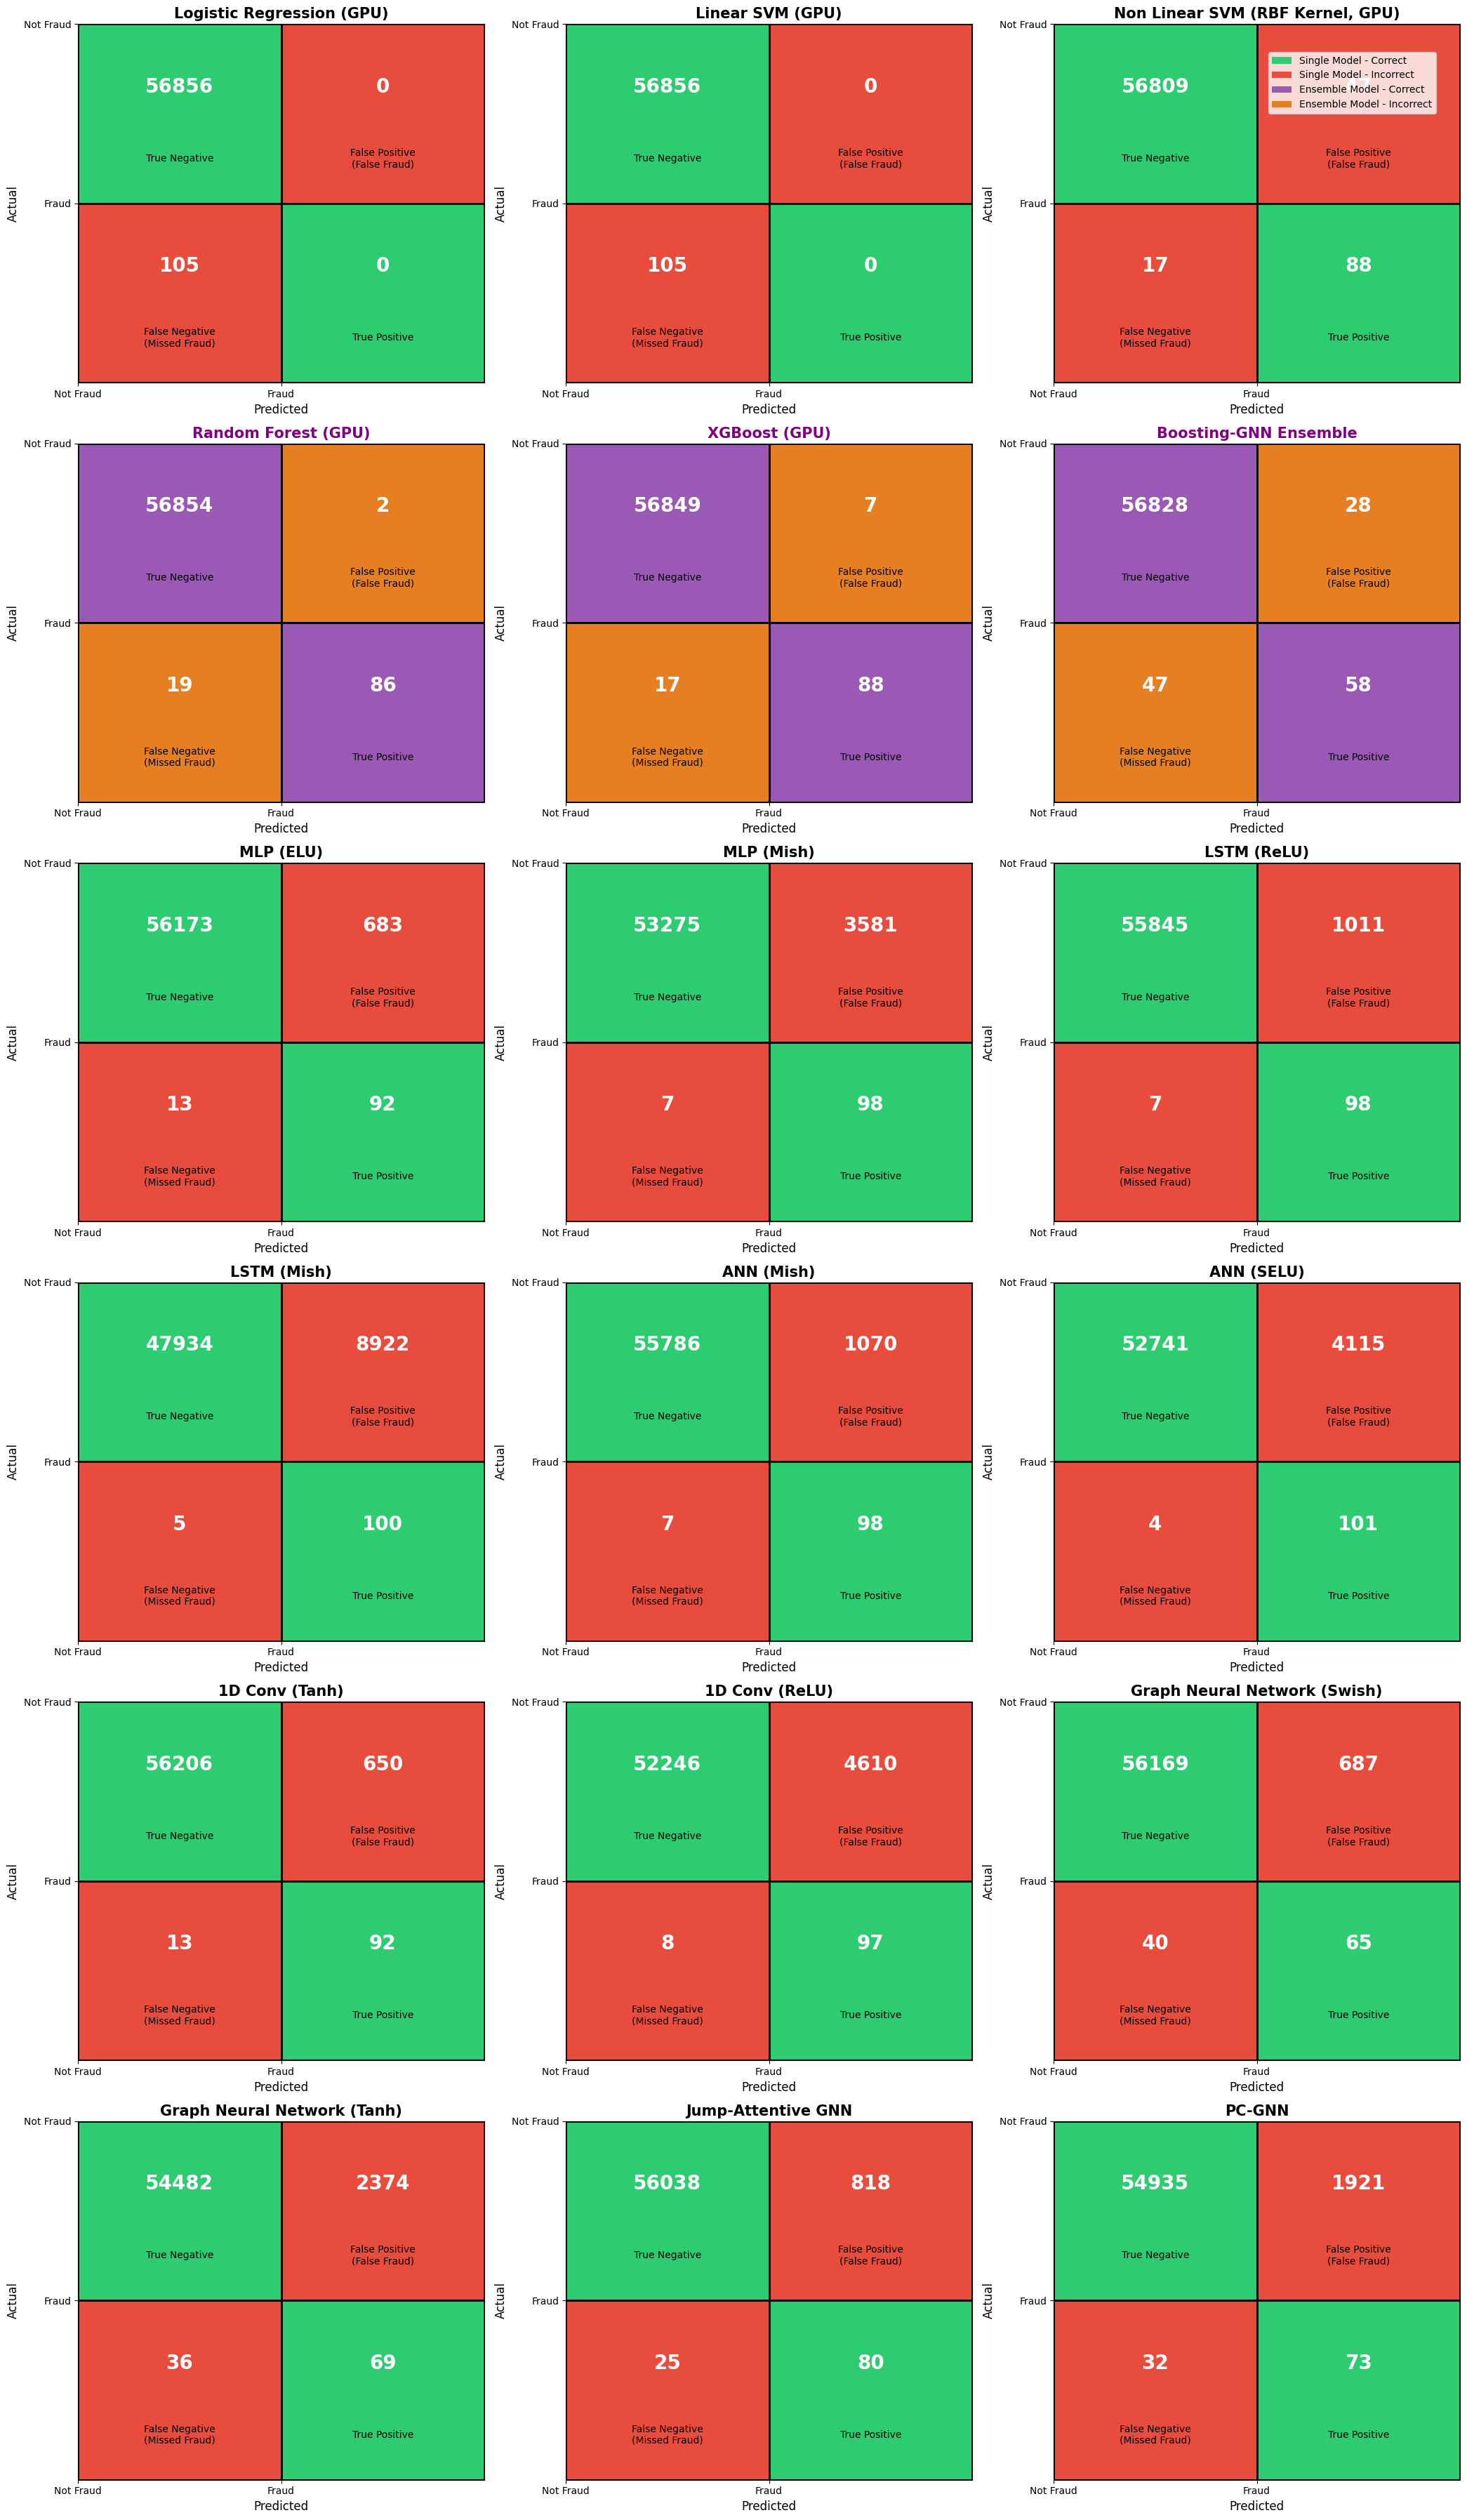

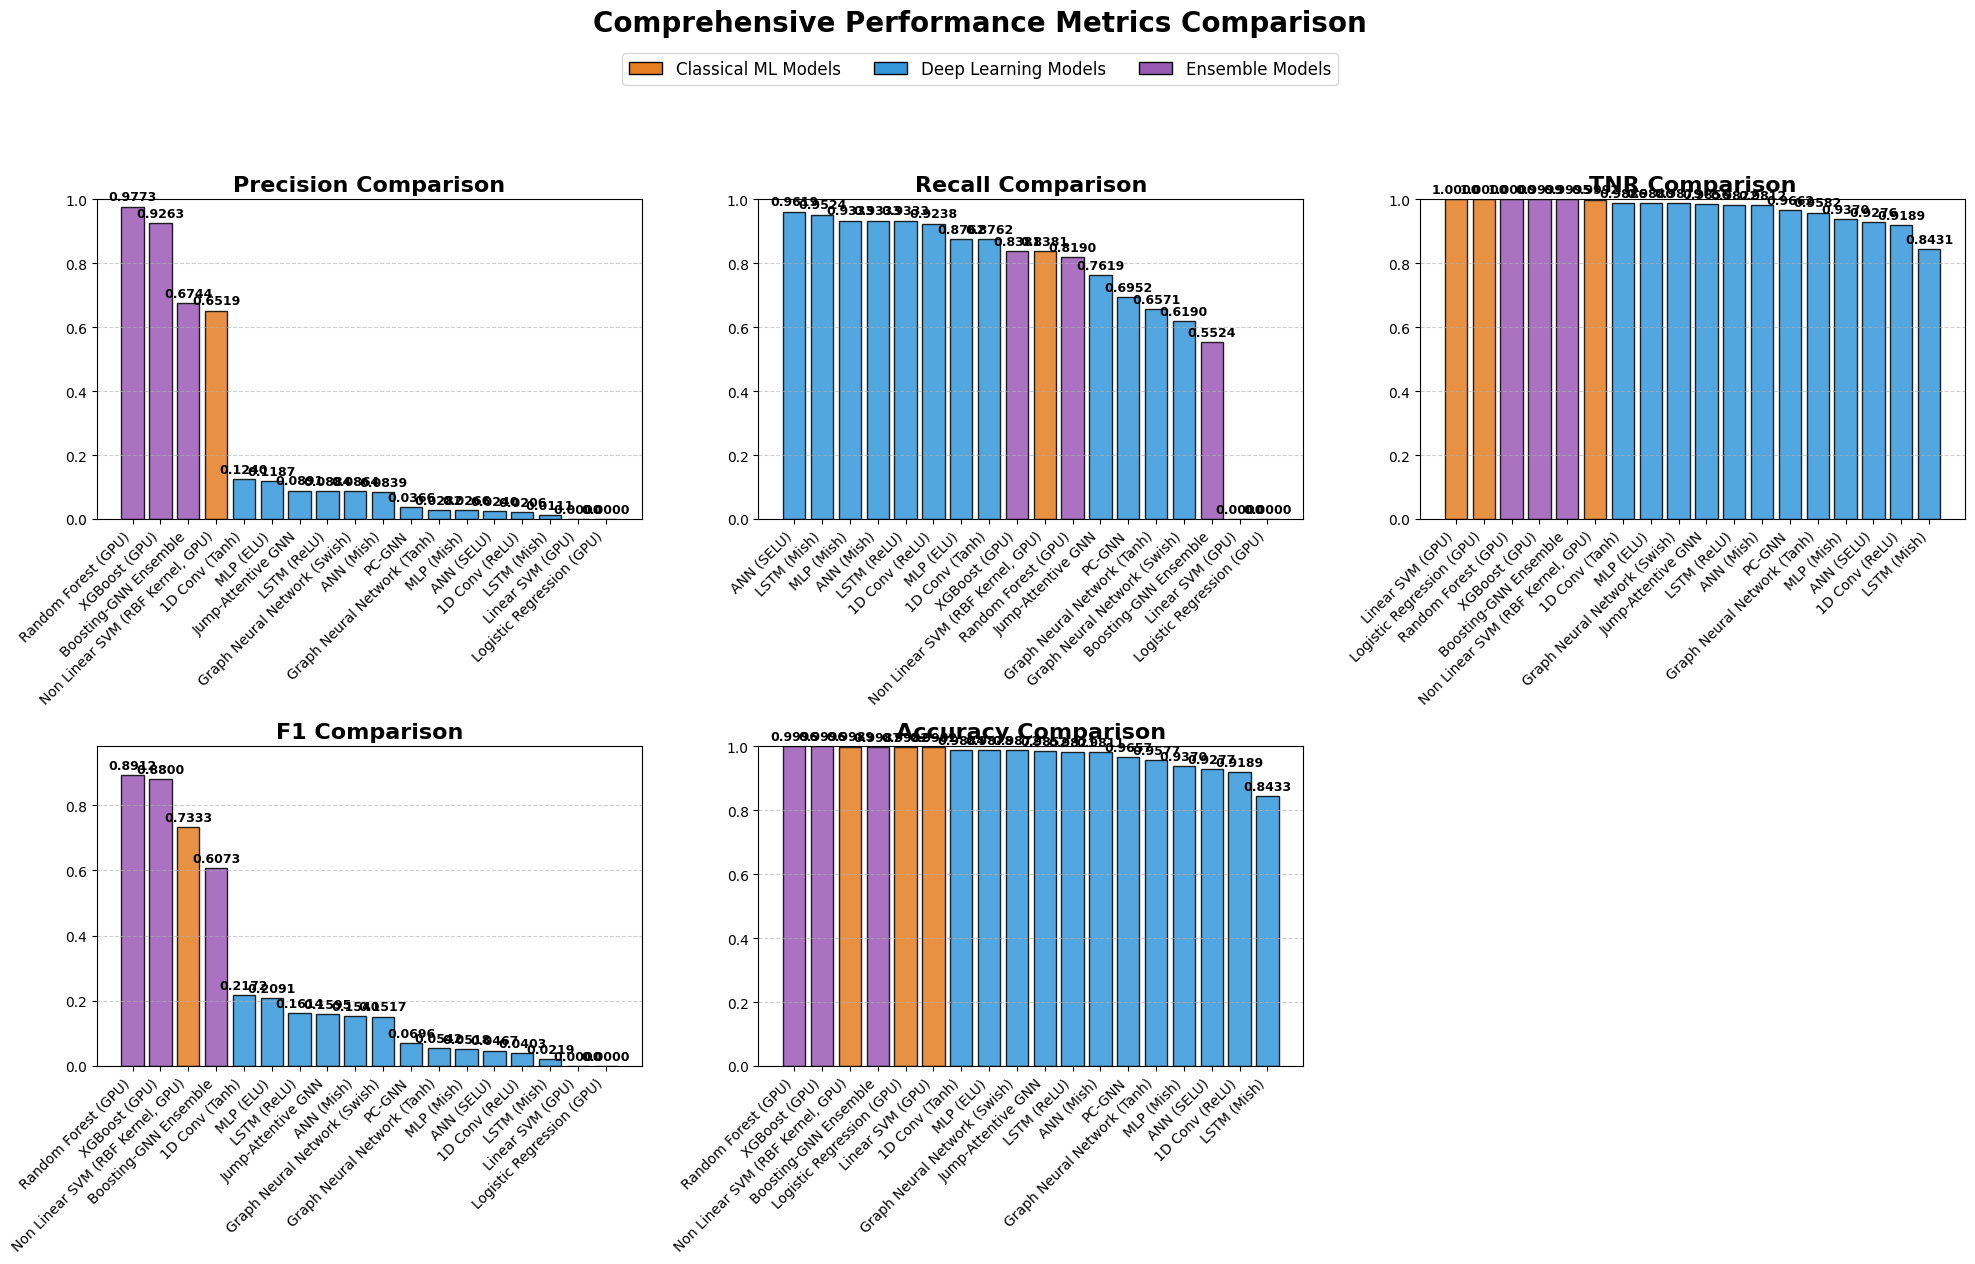


COMPREHENSIVE PERFORMANCE SUMMARY (Ranked by Average Rank)
                           Model  Accuracy  Precision  Recall    TNR     F1  Time (s)  IsEnsemble  Accuracy_Rank  Precision_Rank  Recall_Rank  TNR_Rank  F1_Rank  Avg_Rank
             Random Forest (GPU)    0.9996     0.9773  0.8190 1.0000 0.8912    2.6374        True              1               1           11         3        1    3.4000
                   XGBoost (GPU)    0.9996     0.9263  0.8381 0.9999 0.8800    2.9965        True              2               2            9         4        2    3.8000
Non Linear SVM (RBF Kernel, GPU)    0.9989     0.6519  0.8381 0.9992 0.7333    4.1233       False              3               4            9         6        3    5.0000
                  1D Conv (Tanh)    0.9884     0.1240  0.8762 0.9886 0.2172   13.3512       False              7               5            7         7        5    6.2000
           Boosting-GNN Ensemble    0.9987     0.6744  0.5524 0.9995 0.6073    9.2159

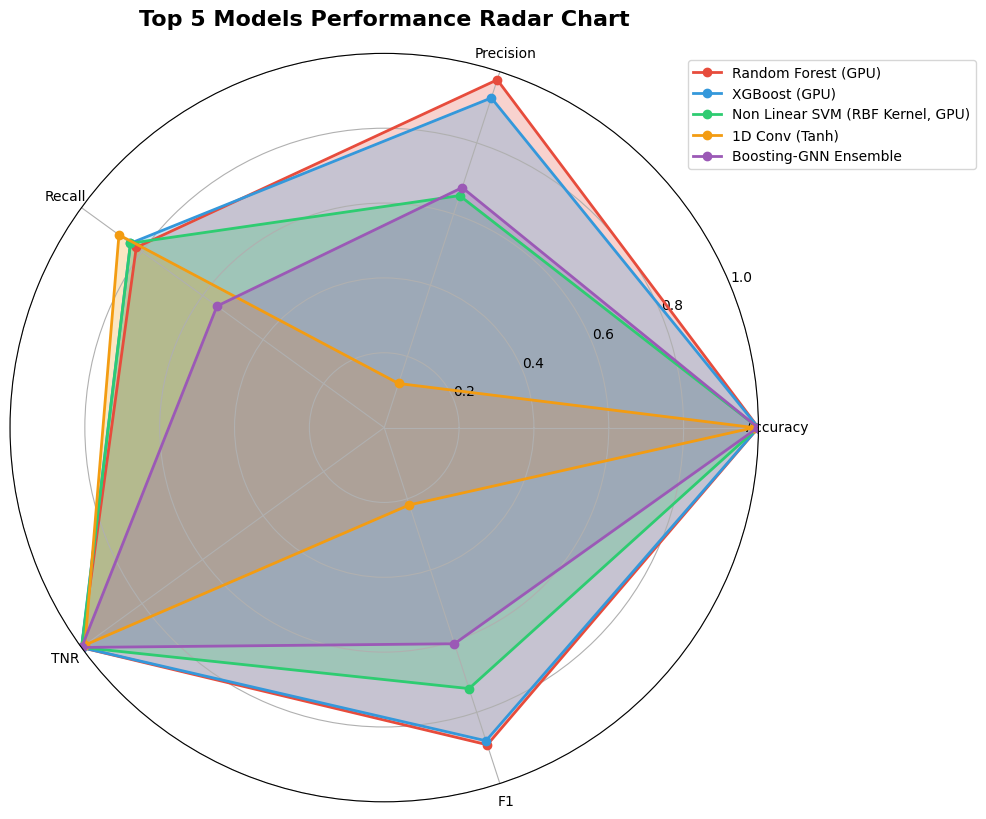

In [92]:
# Store results
results_df = pd.DataFrame(results)
results_filename = f"fraud_detection_results.csv"
results_df.to_csv(results_filename, index=False)
print(f"\nSaved results to {results_filename}")

# Load results
results_df = pd.read_csv("fraud_detection_results.csv")

# Parse confusion matrices
def fix_and_parse_cm(cm_str):
    s = cm_str.replace('\n', ' ').replace('[ ', '[').replace(' ]', ']').strip()
    s = re.sub(r'\]\s*\[', '], [', s)
    s = re.sub(r'(\d)\s+(\d)', r'\1, \2', s)
    return np.array(eval(s))

results_df['Confusion Matrix'] = results_df['Confusion Matrix'].apply(fix_and_parse_cm)

dl_types = ['MLP', 'LSTM', 'ANN', '1D Conv', 'Graph Neural Network', 'Jump-Attentive', 'PC-GNN']
ensemble_models = ['XGBoost', 'Random Forest', 'Boosting-GNN']

results_df['DLType'] = results_df['Model'].apply(
    lambda x: next((dl for dl in dl_types if dl in x), None)
)
results_df['Activation'] = results_df['Model'].apply(
    lambda x: re.search(r'\((.*?)\)', x).group(1) if '(' in x else None
)

results_df['IsEnsemble'] = results_df['Model'].apply(
    lambda x: any(ensemble in x for ensemble in ensemble_models)
)

dl_best_worst = []
for dl in dl_types:
    subset = results_df[results_df['DLType'] == dl]
    if not subset.empty:
        best = subset.loc[subset['Precision'].idxmax()]
        worst = subset.loc[subset['Precision'].idxmin()]
        dl_best_worst.extend([best, worst] if best['Model'] != worst['Model'] else [best])
dl_best_worst_df = pd.DataFrame(dl_best_worst)

classic_df = results_df[results_df['DLType'].isnull()]

plot_df = pd.concat([classic_df, dl_best_worst_df], ignore_index=True)
plot_df = plot_df.drop_duplicates(subset=['Model'])


n_models = len(plot_df)
n_cols = min(3, n_models)
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 6 * n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

cell_labels = [['True Negative', 'False Positive\n(False Fraud)'],
               ['False Negative\n(Missed Fraud)', 'True Positive']]

for idx, (_, row) in enumerate(plot_df.iterrows()):
    cm = row['Confusion Matrix']
    model_name = row['Model']
    is_ensemble = row.get('IsEnsemble', False)

    ax = axes[idx]

    title_color = 'purple' if is_ensemble else 'black'
    ax.set_title(model_name, fontsize=15, fontweight='bold', color=title_color)

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Not Fraud', 'Fraud'])
    ax.set_yticklabels(['Not Fraud', 'Fraud'])

    for i in range(2):
        for j in range(2):
            if is_ensemble:
                color = '#9b59b6' if i == j else '#e67e22'  # Purple/Orange for ensemble
            else:
                color = '#2ecc71' if i == j else '#e74c3c'  # Green/Red for regular models

            rect = plt.Rectangle([j, i], 1, 1, facecolor=color, edgecolor='black', linewidth=2)
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.35, f"{cm[i, j]}", ha='center', va='center',
                    color='white', fontsize=20, fontweight='bold')
            ax.text(j + 0.5, i + 0.75, cell_labels[i][j], ha='center', va='center',
                    color='black', fontsize=10)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.invert_yaxis()

for j in range(len(plot_df), len(axes)):
    fig.delaxes(axes[j])

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Single Model - Correct'),
    Patch(facecolor='#e74c3c', label='Single Model - Incorrect'),
    Patch(facecolor='#9b59b6', label='Ensemble Model - Correct'),
    Patch(facecolor='#e67e22', label='Ensemble Model - Incorrect')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()

metrics = ['Precision', 'Recall', 'TNR', 'F1', 'Accuracy']
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Sort models descending on metric
    sorted_idx = plot_df[metric].argsort()[::-1]
    sorted_models = plot_df['Model'].iloc[sorted_idx]
    sorted_metrics = plot_df[metric].iloc[sorted_idx]

    colors = []
    for j, model in enumerate(sorted_models):
        model_row = plot_df.iloc[sorted_idx[j]]
        is_ensemble = model_row.get('IsEnsemble', False)

        if any(ensemble_name in model for ensemble_name in ['XGBoost', 'Random Forest', 'Boosting-GNN']):
            colors.append('#9b59b6')  # Purple for ensemble
        elif any(dl_type in model for dl_type in ['MLP','ANN','LSTM', '1D Conv', 'Graph Neural Network', 'Jump-Attentive', 'PC-GNN']):
            colors.append('#3498db')  # Blue for DL
        elif any(ml_type in model for ml_type in ['Logistic Regression', 'Linear SVM']):
            colors.append('#e67e22')  # Orange for Classical ML
        else:
            colors.append('#95a5a6')  # Gray for unclassified

    bars = ax.bar(range(len(sorted_models)), sorted_metrics, color=colors, edgecolor='black', alpha=0.85)

    ax.set_title(f'{metric} Comparison', fontsize=16, fontweight='bold')
    ax.set_ylim(0, min(1, max(sorted_metrics) * 1.1))
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right', fontsize=10)

    for k, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

fig.delaxes(axes[5])

legend_elements = [
    plt.Rectangle((0,0), 1, 1, facecolor='#e67e22', edgecolor='black', label='Classical ML Models'),
    plt.Rectangle((0,0), 1, 1, facecolor='#3498db', edgecolor='black', label='Deep Learning Models'),
    plt.Rectangle((0,0), 1, 1, facecolor='#9b59b6', edgecolor='black', label='Ensemble Models')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 1.02))

fig.suptitle('Comprehensive Performance Metrics Comparison', fontsize=20, fontweight='bold', y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


summary_df = plot_df[['Model', 'Accuracy', 'Precision', 'Recall', 'TNR', 'F1', 'Time (s)']].copy()
if 'IsEnsemble' in plot_df.columns:
    summary_df['IsEnsemble'] = plot_df['IsEnsemble']

for metric in ['Accuracy', 'Precision', 'Recall', 'TNR', 'F1']:
    summary_df[f'{metric}_Rank'] = summary_df[metric].rank(ascending=False, method='min').astype(int)

ranking_cols = [col for col in summary_df.columns if col.endswith('_Rank')]
summary_df['Avg_Rank'] = summary_df[ranking_cols].mean(axis=1)
summary_df = summary_df.sort_values('Avg_Rank')

print("\n" + "="*100)
print("COMPREHENSIVE PERFORMANCE SUMMARY (Ranked by Average Rank)")
print("="*100)
print(summary_df.to_string(index=False, float_format='%.4f'))

print("\n" + "="*80)
print("BEST PERFORMERS BY CATEGORY AND METRIC")
print("="*80)

if 'IsEnsemble' in summary_df.columns:
    single_models = summary_df[~summary_df['IsEnsemble']]
    ensemble_models = summary_df[summary_df['IsEnsemble']]

    print("\nSINGLE MODELS:")
    if not single_models.empty:
        best_single_overall = single_models.iloc[0]
        print(f"Overall Best: {best_single_overall['Model']} (Avg Rank: {best_single_overall['Avg_Rank']:.2f})")

        for metric in ['Precision', 'Recall', 'F1']:
            best_single_metric = single_models.loc[single_models[metric].idxmax()]
            print(f"Best {metric}: {best_single_metric['Model']} ({metric}: {best_single_metric[metric]:.4f})")

    print("\nENSEMBLE MODELS:")
    if not ensemble_models.empty:
        best_ensemble_overall = ensemble_models.iloc[0]
        print(f"Overall Best: {best_ensemble_overall['Model']} (Avg Rank: {best_ensemble_overall['Avg_Rank']:.2f})")

        for metric in ['Precision', 'Recall', 'F1']:
            best_ensemble_metric = ensemble_models.loc[ensemble_models[metric].idxmax()]
            print(f"Best {metric}: {best_ensemble_metric['Model']} ({metric}: {best_ensemble_metric[metric]:.4f})")
else:
    best_overall = summary_df.iloc[0]
    print(f"Overall Best Model: {best_overall['Model']} (Avg Rank: {best_overall['Avg_Rank']:.2f})")

    for metric in ['Precision', 'Recall', 'F1', 'TNR']:
        best_metric = summary_df.loc[summary_df[metric].idxmax()]
        print(f"Best {metric}: {best_metric['Model']} ({metric}: {best_metric[metric]:.4f})")

top_5_models = summary_df.head(5)
metrics_for_radar = ['Accuracy', 'Precision', 'Recall', 'TNR', 'F1']

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

N = len(metrics_for_radar)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Plot each model
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
for idx, (_, model_data) in enumerate(top_5_models.iterrows()):
    values = [model_data[metric] for metric in metrics_for_radar]
    values += values[:1]  # Complete the circle

    ax.plot(angles, values, 'o-', linewidth=2, label=model_data['Model'], color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar)
ax.set_ylim(0, 1)
ax.set_title('Top 5 Models Performance Radar Chart', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()